In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Loading datasets
train_data = pd.read_csv("./datasets/train.csv")
test_data = pd.read_csv("./datasets/test.csv")

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    float64
dtypes: float64(3), int64(6), object(3)
memory usage: 83.7+ KB


<span style="color:red">Missing age and cabin of some passengers</span>

In [18]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,1.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,0.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,0.0


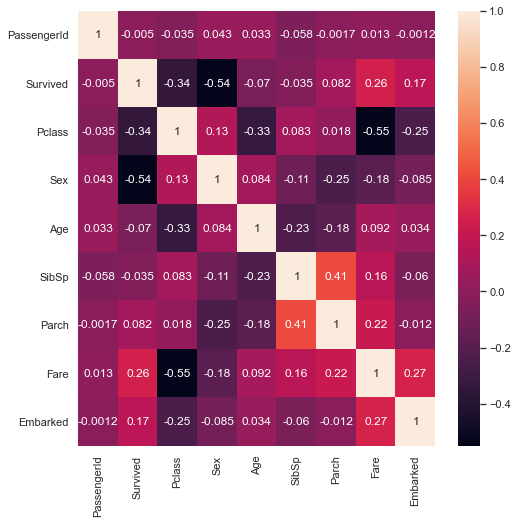

In [19]:
# Finding corelation between each feature
sns.set()
plt.figure(figsize=(8,8))
corr_Matrix = train_data.corr()
sns.heatmap(corr_Matrix, annot=True)

In [20]:
# Changing some features for later analysis
train_data['Sex'].replace('female', 0,inplace=True)
train_data['Sex'].replace('male', 1,inplace=True)
train_data['Age'].fillna(train_data['Age'].mean(), inplace=True)
train_data['Embarked'].replace('S', 0, inplace=True)
train_data['Embarked'].replace('C', 1, inplace=True)
train_data['Embarked'].replace('Q', 2, inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    float64
dtypes: float64(3), int64(6), object(3)
memory usage: 83.7+ KB


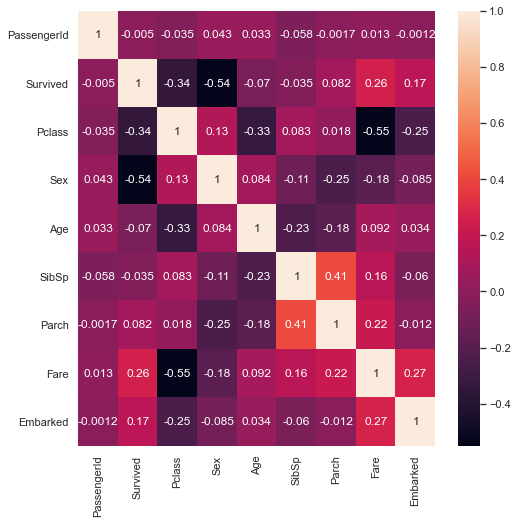

In [21]:
plt.figure(figsize=(8,8))
corr_Matrix = train_data.corr()
sns.heatmap(corr_Matrix, annot=True)

Correlation between survived and age is very low so it may over-fit the data.
Checking if parch or sibsp affects if person survived or not

In [23]:
train_data[train_data["Parch"] == 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,NaN,0.0
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",0,4.0,1,1,PP 9549,16.7000,G6,0.0
16,17,0,3,"Rice, Master. Eugene",1,2.0,4,1,382652,29.1250,NaN,0.0
24,25,0,3,"Palsson, Miss. Torborg Danira",0,8.0,3,1,349909,21.0750,NaN,0.0
50,51,0,3,"Panula, Master. Juha Niilo",1,7.0,4,1,3101295,39.6875,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
856,857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",0,45.0,1,1,36928,164.8667,NaN,0.0
869,870,1,3,"Johnson, Master. Harold Theodor",1,4.0,1,1,347742,11.1333,NaN,0.0
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",0,47.0,1,1,11751,52.5542,D35,0.0
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",0,56.0,0,1,11767,83.1583,C50,1.0
